## HOMEWORK

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In [82]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [83]:
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv', usecols=select_cols)

In [84]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [85]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [86]:
df.total_bedrooms = df.total_bedrooms.fillna(0)



    Apply the log transform to median_house_value.
    Do train/validation/test split with 60%/20%/20% distribution.
    Use the train_test_split function and set the random_state parameter to 1.



In [87]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df['log_house_value']=np.log1p(df.median_house_value)

In [88]:
df_full_train,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

In [89]:
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
y_train=df_train.log_house_value.values
y_test=df_test.log_house_value.values
y_val=df_val.log_house_value.values

In [90]:
del df_train['log_house_value']
del df_test['log_house_value']
del df_val['log_house_value']
del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']

We will use DictVectorizer to turn train and validation into matrices.

In [91]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dv=DictVectorizer(sparse=False)

In [92]:
train_dict=df_train.to_dict(orient='records')
val_dict=df_val.to_dict(orient='records')

In [93]:
X_train=dv.fit_transform(train_dict)
X_val=dv.transform(val_dict)

### Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1

In [94]:
dt=DecisionTreeRegressor(max_depth=1)

In [95]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [96]:
print(export_text(dt,feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]





    Which feature is used for splitting the data?

    Answer: ocean_proximity=INLAND





### Question 2

Train a random forest model with these parameters:

    n_estimators=10
    random_state=1
    n_jobs=-1 (optional-to make training faster)



In [97]:
rf=RandomForestRegressor(n_estimators=10,random_state=1)

In [98]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [99]:
y_pred=rf.predict(X_val)
mean_squared_error(y_pred,y_val)

0.06038733337686411



    What's the RMSE of this model on validation?

    Answer: 0.05



### Question 3

Now let's experiment with the n_estimators parameter

    Try different values of this parameter from 10 to 200 with step 10.
    Set random_state to 1.
    Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

In [100]:
scores=[]
for c in range(10,201,10):
    rf=RandomForestRegressor(n_estimators=c,random_state=1)
    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_val)
    score=mean_squared_error(y_pred,y_val)
    scores.append((c,score))

In [101]:
df_scores=pd.DataFrame(scores,columns=['n_estimators','RMSE'])

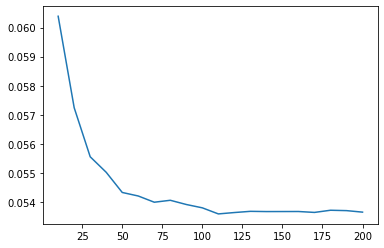

In [102]:
plt.plot(df_scores.n_estimators,df_scores.RMSE)



    After which value of n_estimators does RMSE stop improving?

    Answer: 75





### Question 4

Let's select the best max_depth:

    Try different values of max_depth: [10, 15, 20, 25].
    For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
    Fix the random seed: random_state=1.



In [103]:
scores=[]
for c in [10, 15, 20, 25]:
    rf=RandomForestRegressor(n_estimators=75,random_state=1,max_depth=c)
    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_val)
    score=mean_squared_error(y_pred,y_val)
    scores.append((c,score))

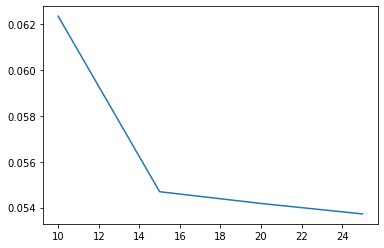

In [104]:
df_scores=pd.DataFrame(scores,columns=['max_depth','RMSE'])
plt.plot(df_scores.max_depth,df_scores.RMSE)



    What's the best max_depth:

    Answer: 25





### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:

    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1 (optional)

Get the feature importance information from this model


In [105]:
rf=RandomForestRegressor(n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [106]:
feature_importances = pd.DataFrame(rf.feature_importances_, index =dv.get_feature_names(),  columns=['importance'])

In [107]:
feature_importances.sort_values('importance',ascending=False)

,importance
median_income,0.362913
ocean_proximity=INLAND,0.310901
latitude,0.101334
longitude,0.096265
housing_median_age,0.033094
population,0.030918
total_rooms,0.020536
total_bedrooms,0.019041
households,0.016957
ocean_proximity=NEAR OCEAN,0.004228




    What's the most important feature?

    Answer: median_income





### Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

    Install XGBoost.
    Create DMatrix for train and validation
    Create a watchlist
    Train a model with these parameters for 100 rounds:

xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}



In [108]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [109]:
xgb_param = {
'eta': 0.3,
'max_depth': 6,
'min_child_weight': 1,

'objective': 'reg:squarederror',
'nthread': 8,

'seed': 1,
'verbosity': 1,

}
model=xgb.train(xgb_param,dtrain,num_boost_round=100)
y_pred=model.predict(dval)
mean_squared_error(y_pred,y_val)

0.05111930390108557

Now, change eta from 0.3 to 0.1

In [110]:
xgb_param = {
'eta': 0.1,
'max_depth': 6,
'min_child_weight': 1,

'objective': 'reg:squarederror',
'nthread': 8,

'seed': 1,
'verbosity': 1,

}
model=xgb.train(xgb_param,dtrain,num_boost_round=100)
y_pred=model.predict(dval)
mean_squared_error(y_pred,y_val)

0.05314943034462633



    Which eta leads to the best RMSE score on the validation dataset?

    Answer: 0.3

